# Imports

In [47]:
%matplotlib widget
from scipy.io import loadmat
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Data Loading and Pre-processing

In [48]:
# Load the MATLAB files
gt_mat = loadmat("Data/3D_recon/FF/recon_p06.FF01.u_FDK_ROI_fullView.mat")
fdk_mat = loadmat("Data/3D_recon/FF/recon_p06.FF01.u_FDK_ROI.mat")
pl_mat = loadmat("Data/3D_recon/FF/recon_p06.FF01.u_PL_ROI.b1.mat")

# Print the keys of the loaded dictionaries
print(gt_mat.keys())
print(fdk_mat.keys())
print(pl_mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'u_FDK_ROI_fullView'])
dict_keys(['__header__', '__version__', '__globals__', 'u_FDK_ROI'])
dict_keys(['__header__', '__version__', '__globals__', 'u_PL_ROI'])


In [49]:
# Extract the scan data
gt = gt_mat['u_FDK_ROI_fullView']
fdk = fdk_mat['u_FDK_ROI']
pl = pl_mat['u_PL_ROI']

# Check their shapes
print("Initial shapes:")
print("GT:", gt.shape)
print("FDK:", fdk.shape)
print("PL:", pl.shape)

# Remove the first and last 20 slices
gt = gt[..., 20:-20]
fdk = fdk[..., 20:-20]
pl = pl[..., 20:-20]

# Crop
gt = gt[128:-128, 128:-128]
fdk = fdk[128:-128, 128:-128]
pl = pl[128:-128, 128:-128]

# Check the new shapes (for verification)
print("\nShapes after removing slices:")
print("GT:", gt.shape)
print("FDK:", fdk.shape)
print("PL:", pl.shape)

Initial shapes:
GT: (512, 512, 200)
FDK: (512, 512, 200)
PL: (512, 512, 200)

Shapes after removing slices:
GT: (256, 256, 160)
FDK: (256, 256, 160)
PL: (256, 256, 160)


In [50]:
# NOTE: This is a numpy array, not a torch tensor
ddCNN = torch.load("Data/3D_recon/FF/p06.FF01_IResNet_MK6_DS14.2_run1_3D.pt", weights_only=False)

# The loaded array should already have the correct number of slices
ddCNN.shape

(256, 256, 160)

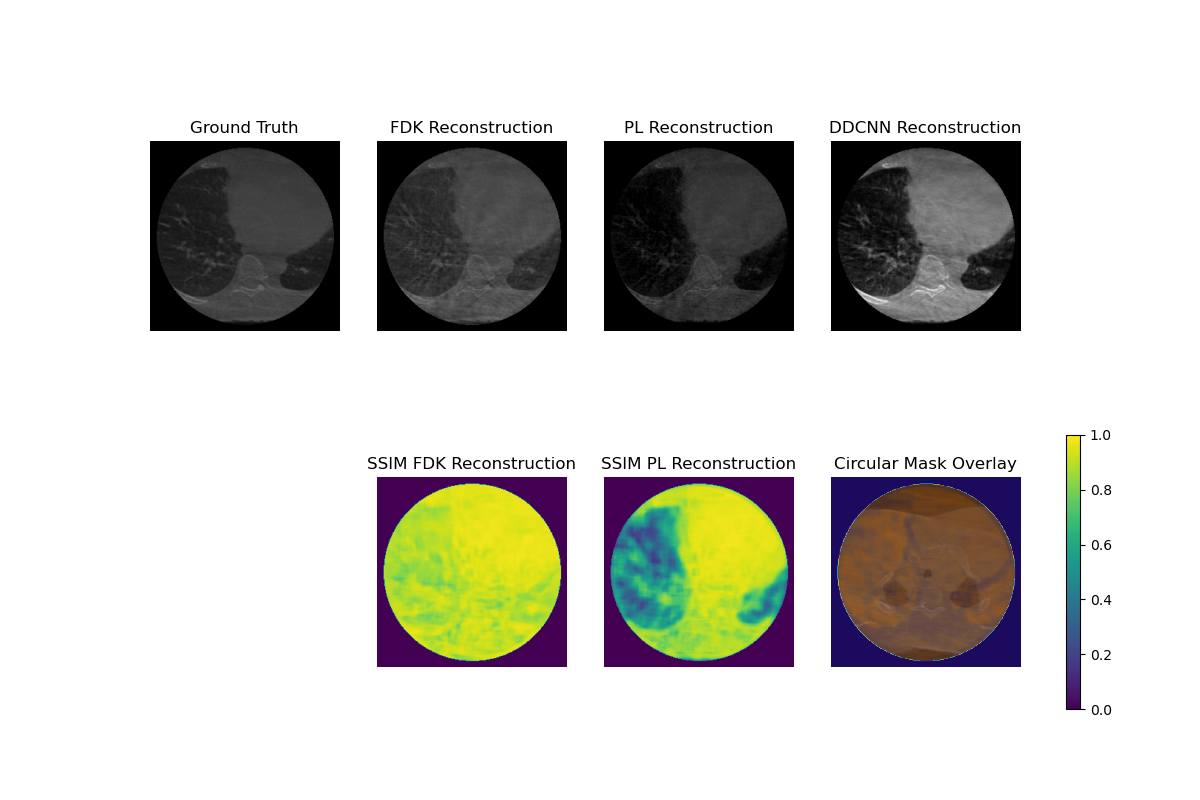

In [51]:
# gt is your ground truth volume of shape (H, W, N)
first_slice = gt[:, :, 0]

# 1. Create a binary foreground mask from non-zero pixels
fg = first_slice != 0

# 2. Estimate center as image center
H, W = first_slice.shape
cy, cx = H / 2.0, W / 2.0

# 3. Compute distances of all foreground pixels to center
ys, xs = np.nonzero(fg)
dists = np.sqrt((ys - cy)**2 + (xs - cx)**2)

# 4. Estimate radius as the 99th percentile of those distances
radius = np.percentile(dists, 99)

# 5. Build your circular mask
Y, X = np.ogrid[:H, :W]
mask = (Y - cy)**2 + (X - cx)**2 <= radius**2

# Plot the mask on top of the first slice
plt.imshow(first_slice, cmap='gray', alpha=0.5)
plt.imshow(mask, cmap='jet', alpha=0.5)
plt.title("Circular Mask Overlay")
plt.axis('off')
plt.show()

# Plotting

In [54]:
def show_volumes(gt, recons, recon_titles, slice_idx):
    """
    gt          : ndarray, ground truth volume (H, W, N)
    recons      : list of ndarrays, reconstructions (each H, W, N)
    recon_titles: list of str, titles for recs
    slice_idx   : int, which slice to display
    """

    # build full lists
    volumes = [gt] + recons
    titles  = ['Ground Truth'] + recon_titles

    # proceed without per‐slice normalization
    n = len(volumes)
    fig, axes = plt.subplots(2, n, figsize=(3*n, 8))

    # first row: original volumes (now scaled)
    for i, (vol, title) in enumerate(zip(volumes, titles)):
        ax = axes[0, i]
        slice_ = vol[..., slice_idx]
        # normalize to [0, 1]
        slice_ = (slice_ - np.min(slice_)) / (np.max(slice_) - np.min(slice_)) # TODO normalize?
        ax.imshow(slice_ * mask, cmap='gray', vmin=0, vmax=1) # TODO mask?
        ax.set_title(title)
        ax.axis('off')

    # second row: SSIM maps (skip GT in col 0)
    axes[1, 0].axis('off')
    ssim_axes = []
    for i in range(1, n):
        ax = axes[1, i]
        gt_slice    = gt[..., slice_idx]
        recon_slice = recons[i-1][..., slice_idx]
        # normalize slices to [0, 1]
        gt_slice    = (gt_slice - np.min(gt_slice)) / (np.max(gt_slice) - np.min(gt_slice)) # TODO normalize?
        recon_slice = (recon_slice - np.min(recon_slice)) / (np.max(recon_slice) - np.min(recon_slice)) # TODO normalize?
        _, ssim_map = ssim(
            gt_slice, recon_slice,
            full=True,
            data_range=1.0,
            K1=0.03, K2=0.06, win_size=11
        )
        im = ax.imshow(ssim_map * mask, cmap='viridis', vmin=0, vmax=1) # TODO mask?
        ax.set_title(f'SSIM {recon_titles[i-1]}')
        ax.axis('off')
        ssim_axes.append(ax)

    # shared colorbar for SSIM
    fig.colorbar(im, ax=ssim_axes, location='right', fraction=0.02, pad=0.02)
    fig.subplots_adjust(right=0.85)

    plt.show()

In [ ]:
recons = [fdk, pl, ddCNN]
recon_titles = [
    'FDK Reconstruction',
    'PL Reconstruction',
    'DDCNN Reconstruction'
]

interact(
    show_volumes,
    gt=fixed(gt),
    recons=fixed(recons),
    recon_titles=fixed(recon_titles),
    slice_idx=IntSlider(
        min=0,
        max=gt.shape[2] - 1,
        step=1,
        value=0,
        description='Slice'
    )
)

interactive(children=(IntSlider(value=0, description='Slice', max=159), Output()), _dom_classes=('widget-inter…

<function __main__.show_volumes(gt, recons, recon_titles, slice_idx)>